In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers

from tqdm import tqdm

# import glob
# import imageio
# import os
# import PIL
# import time

tf.__version__
tf.keras.backend.set_floatx('float32')

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = (train_images-127.5)/127.5

train_images = np.stack((train_images, train_images, train_images), axis=3)
train_images_color = train_images.copy()
# train_images_color[train_images>0] = np.random.uniform(0, 255, train_images_color[train_images>0].shape)
train_images_color[:, :, :, 1] = -1
train_images_color[:, :, :, 2] = -1

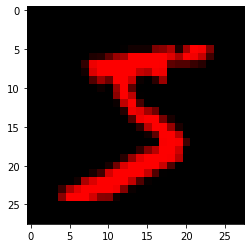

In [3]:
plt.imshow(train_images_color[0]/2+0.5)

In [4]:
# A space is the original space
# B space is the color space

def create_generator_model_A2B():
    gm = tf.keras.Sequential()
    gm.add(layers.Flatten(input_shape=(28, 28, 3)))
    gm.add(layers.Dense(28*28*3, activation='tanh'))
    gm.add(layers.Reshape((28, 28, 3)))
    assert gm.output_shape == (None, 28, 28, 3)
    
    
#     gm.add(layers.Conv2D(100, (5,5), strides=(1,1), padding='same', use_bias=False))
    
    
    
#     gm.add(layers.Dense(7*7*256, use_bias=False, input_shape=(28, 28, 3)))
#     gm.add(layers.BatchNormalization())
#     gm.add(layers.LeakyReLU())

#     gm.add(layers.Reshape((7, 7, 256)))
#     assert gm.output_shape == (None, 7, 7, 256) # Note: None is the batch size

#     gm.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert gm.output_shape == (None, 7, 7, 128)
#     gm.add(layers.BatchNormalization())
#     gm.add(layers.LeakyReLU())

#     gm.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert gm.output_shape == (None, 14, 14, 64)
#     gm.add(layers.BatchNormalization())
#     gm.add(layers.LeakyReLU())

#     gm.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert gm.output_shape == (None, 28, 28, 3)

    return gm
    
def create_generator_model_B2A():
    return create_generator_model_A2B()


def create_discriminator_model_A():
    dm = tf.keras.Sequential()
    dm.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Flatten())
    dm.add(layers.Dense(1))
    return dm

def create_discriminator_model_B():
    return create_discriminator_model_A()


In [5]:
gm_a2b = create_generator_model_A2B()
gm_b2a = create_generator_model_B2A()

dm_a = create_discriminator_model_A()
dm_b = create_discriminator_model_B()

W0405 21:46:46.953542 4501568960 base_layer.py:1790] Layer flatten is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0405 21:46:46.999582 4501568960 base_layer.py:1790] Layer flatten_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.


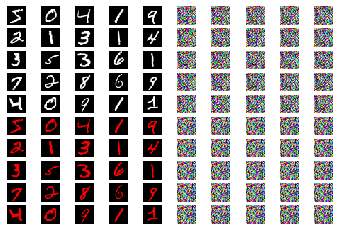

In [6]:
rows = 5
columns = 5
# vis_noises = np.random.normal(0, 1, (rows*columns, 100))

def show_generator_model_images(gm_a2b, gm_b2a):
    real_a = train_images[:rows*columns]
    real_b = train_images_color[:rows*columns]
    fake_b = gm_a2b(real_a, training=False)
    fake_a = gm_b2a(real_b, training=False)
    

    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1)
            plt.imshow(real_a[column+row*columns]/2+0.5)
            plt.axis('off')
    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1+rows*columns*2)
            plt.imshow(real_b[column+row*columns]/2+0.5)
            plt.axis('off')
            
    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1+columns)
            plt.imshow(fake_b[column+row*columns]/2+0.5)
            plt.axis('off')
    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1+rows*columns*2+columns)
            plt.imshow(fake_a[column+row*columns]/2+0.5)
            plt.axis('off')
    
    
#     for i in range(4*rows*columns):
#         plt.subplot(2*rows, 2*columns, i+1)
#         row = i / (2*columns)
#         column = i % (2*columns)
#         if column < columns: 
#             if row < rows:
#             plt.imshow(real_a, cmap='gray')
#             # plt.colorbar()
#             plt.axis('off')
    
    
show_generator_model_images(gm_a2b, gm_b2a)

In [7]:
g_a2b_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
g_b2a_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_a_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_b_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()
# mean_square_error = tf.keras.losses.MeanSquaredError()

def cycle_loss(ori_img, cycle_img):
    return mean_absolute_error(ori_img, cycle_img)
def identity_loss(ori_img, same_img):
    return mean_absolute_error(ori_img, same_img)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # want to correctly identify real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # want to correctly identify fake
    return real_loss + fake_loss


In [19]:
@tf.function
def train_step(a_image_batch, b_image_batch):    
    # gradient tapes needed to keep track of gradients (auto differentiation)
    with tf.GradientTape(persistent=True) as tape:
        # aba cycle
        fake_b = gm_a2b(a_image_batch, training=True)
        cycle_a = gm_b2a(fake_b, training=True)
        
        # bab cycle
        fake_a = gm_b2a(b_image_batch, training=True)
        cycle_b = gm_a2b(fake_a, training=True)
        
        # identity
        same_a = gm_b2a(a_image_batch, training=True)
        same_b = gm_a2b(b_image_batch, training=True)
        
        real_output_a = dm_a(a_image_batch, training=True)
        fake_output_a = dm_a(fake_a, training=True)
        real_output_b = dm_b(b_image_batch, training=True)
        fake_output_b = dm_b(fake_b, training=True)
        
        d_loss_a = discriminator_loss(real_output_a, fake_output_a)
        d_loss_b = discriminator_loss(real_output_b, fake_output_b)
        
        c_loss = cycle_loss(a_image_batch, cycle_a) + cycle_loss(b_image_batch, cycle_b)
        i_loss_a = identity_loss(a_image_batch, same_a)
        i_loss_b = identity_loss(b_image_batch, same_b)
        
        g_loss_a2b = generator_loss(fake_output_b) + i_loss_a + c_loss
        g_loss_b2a = generator_loss(fake_output_a) + i_loss_b + c_loss

    grad_a2b = tape.gradient(g_loss_a2b, gm_a2b.trainable_variables)
    grad_b2a = tape.gradient(g_loss_b2a, gm_b2a.trainable_variables)
    grad_da = tape.gradient(d_loss_a, dm_a.trainable_variables)
    grad_db = tape.gradient(d_loss_b, dm_b.trainable_variables)
    
    g_a2b_optim.apply_gradients(zip(grad_a2b, gm_a2b.trainable_variables))
    g_b2a_optim.apply_gradients(zip(grad_b2a, gm_b2a.trainable_variables))
    d_a_optim.apply_gradients(zip(grad_da, dm_a.trainable_variables))
    d_b_optim.apply_gradients(zip(grad_db, dm_b.trainable_variables))

In [20]:
batch_size = 100

def train(epochs):
    for epoch in range(epochs):
        
        for i_batch in tqdm(range(int(train_images.shape[0]/batch_size))):
            a_image_batch = train_images[i_batch*batch_size:(i_batch+1)*batch_size]
            b_image_batch = train_images_color[i_batch*batch_size:(i_batch+1)*batch_size]
            train_step(a_image_batch, b_image_batch)
            
            if i_batch%50==0:
                show_generator_model_images(gm_a2b, gm_b2a)
                plt.show()
#                 plt.savefig(f'mnist_gan/epoch_{epoch:03d}_step_{i_batch:03d}')
#                 plt.close()


  0%|          | 0/600 [00:00<?, ?it/s]

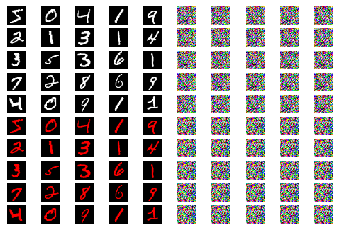

  8%|▊         | 50/600 [00:37<05:42,  1.61it/s] 

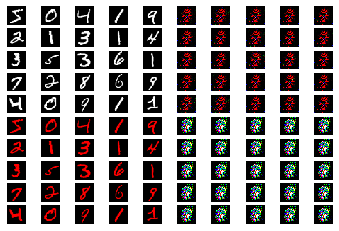

 17%|█▋        | 100/600 [01:14<05:11,  1.60it/s]

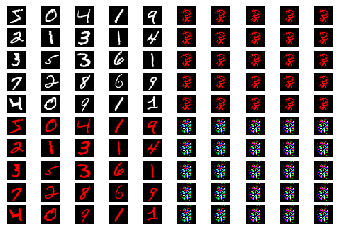

 25%|██▌       | 150/600 [01:52<04:38,  1.61it/s]

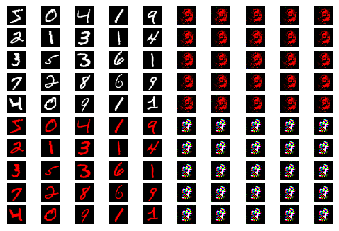

 33%|███▎      | 200/600 [02:26<04:22,  1.52it/s]

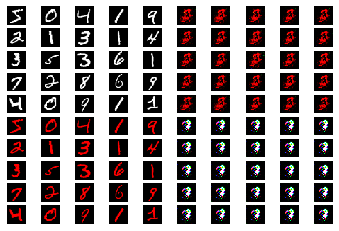

 42%|████▏     | 250/600 [03:00<03:42,  1.57it/s]

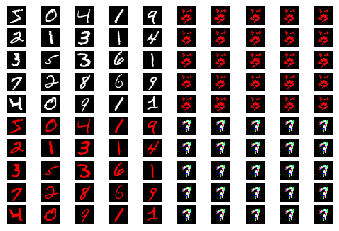

 50%|█████     | 300/600 [03:37<03:34,  1.40it/s]

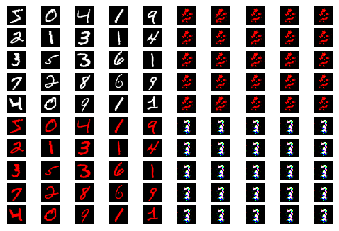

 58%|█████▊    | 350/600 [04:19<02:36,  1.59it/s]

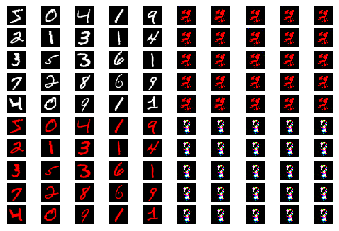

 67%|██████▋   | 400/600 [04:53<02:10,  1.53it/s]W0405 21:54:35.007557 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:54:35.040946 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:54:35.094913 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


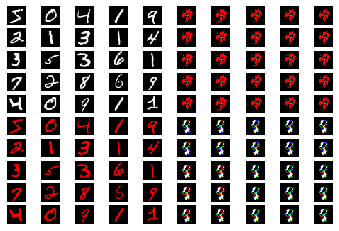

 75%|███████▌  | 450/600 [05:27<01:33,  1.60it/s]W0405 21:55:08.696814 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:08.954085 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:09.064065 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:09.096091 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:09.180624 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:09.195163 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

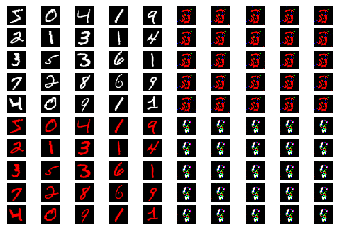

 83%|████████▎ | 500/600 [06:02<01:22,  1.21it/s]W0405 21:55:45.564359 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:45.761222 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:45.801548 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:46.006010 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:46.041057 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:55:46.056849 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

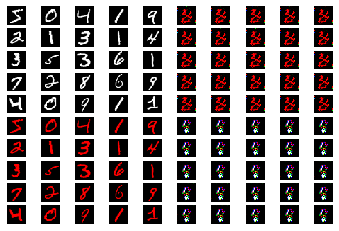

 92%|█████████▏| 550/600 [06:42<00:30,  1.61it/s]W0405 21:56:23.326668 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:23.547980 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:23.608816 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:23.709495 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:23.743750 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:23.792859 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

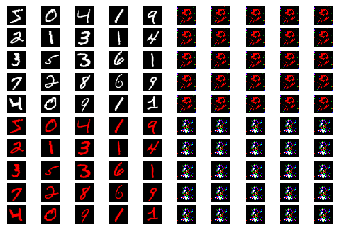

  0%|          | 0/600 [00:00<?, ?it/s]W0405 21:56:57.298939 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:57.342394 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:57.483155 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:57.524729 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:57.592718 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:57.608438 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:56:57.6435

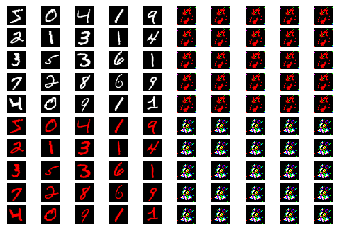

  8%|▊         | 50/600 [00:34<05:44,  1.59it/s]W0405 21:57:32.035161 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:57:32.071197 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:57:32.115498 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:57:32.131021 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:57:32.337158 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:57:32.353892 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:5

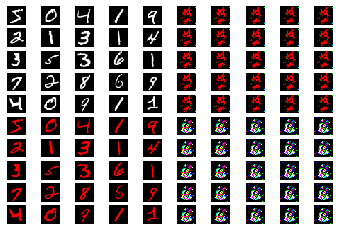

 17%|█▋        | 100/600 [01:09<05:21,  1.56it/s]W0405 21:58:06.334778 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:06.364212 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:06.378453 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:06.442108 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:06.619693 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:06.686728 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

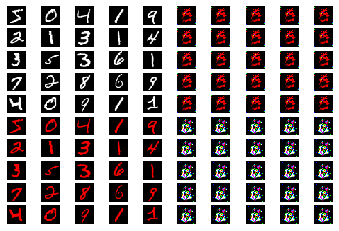

 25%|██▌       | 150/600 [01:42<04:37,  1.62it/s]W0405 21:58:40.022635 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:40.036791 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:40.073273 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:40.101879 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:40.119735 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:58:40.242399 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

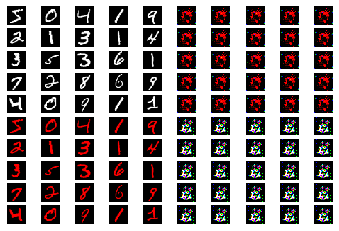

 33%|███▎      | 200/600 [02:16<04:05,  1.63it/s]W0405 21:59:13.648152 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:13.689961 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:13.704151 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:13.741818 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:13.773420 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:13.788282 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

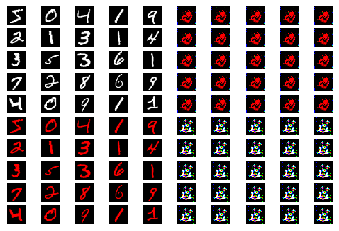

 42%|████▏     | 250/600 [03:00<04:47,  1.22it/s]W0405 21:59:57.309279 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:57.336246 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:57.359685 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:57.381519 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:57.397091 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:59:57.419647 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 21:

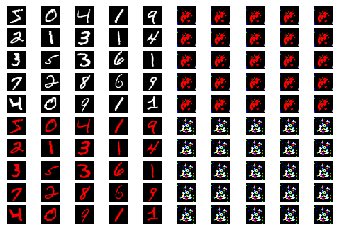

 50%|█████     | 300/600 [03:36<03:07,  1.60it/s]W0405 22:00:33.563224 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:00:33.595724 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:00:33.611551 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:00:33.629207 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:00:33.648910 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:00:33.662765 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

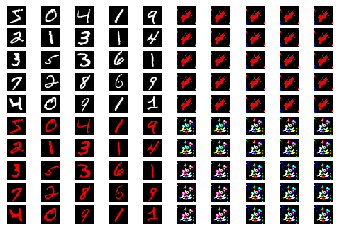

 58%|█████▊    | 350/600 [04:11<02:34,  1.62it/s]W0405 22:01:08.542914 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:08.556926 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:08.581317 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:08.599078 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:08.636784 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:08.681524 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

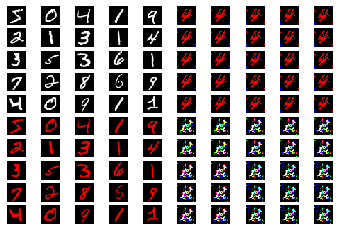

 67%|██████▋   | 400/600 [04:45<02:03,  1.62it/s]W0405 22:01:42.725409 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:42.755674 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:42.770615 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:42.785553 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:42.806594 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:01:42.823127 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

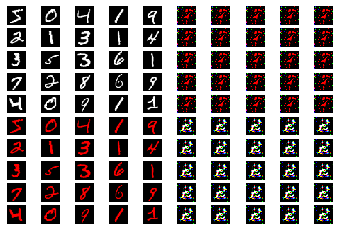

 75%|███████▌  | 450/600 [05:19<01:33,  1.60it/s]W0405 22:02:17.026207 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:17.061679 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:17.082388 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:17.097852 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:17.126985 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:17.150614 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

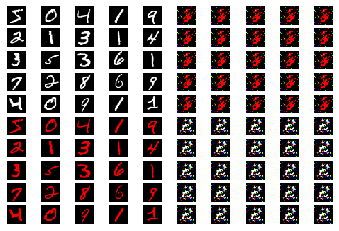

 83%|████████▎ | 500/600 [05:54<01:02,  1.60it/s]W0405 22:02:51.545292 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:51.576030 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:51.590798 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:51.609029 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:51.628392 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:02:51.655548 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

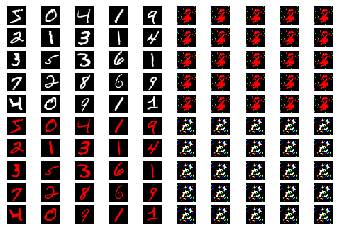

 92%|█████████▏| 550/600 [06:31<00:40,  1.23it/s]W0405 22:03:28.806438 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:03:28.820293 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:03:28.850787 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:03:28.872307 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:03:28.898898 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:03:28.927687 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

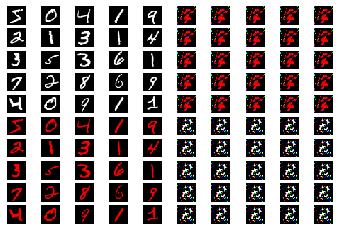

  0%|          | 0/600 [00:00<?, ?it/s]W0405 22:04:03.089895 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:03.110707 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:03.127403 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:03.148024 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:03.170187 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:03.196028 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:03.2119

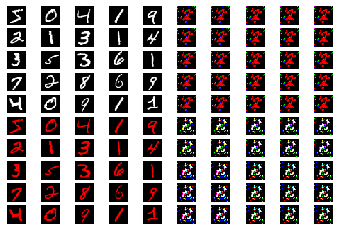

  8%|▊         | 50/600 [00:34<05:37,  1.63it/s]W0405 22:04:37.084656 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:37.098228 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:37.118911 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:37.142149 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:37.164094 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:04:37.190206 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:0

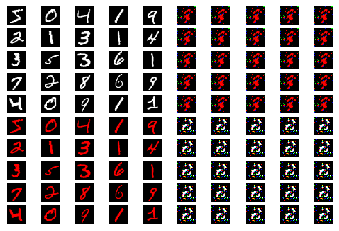

 17%|█▋        | 100/600 [01:09<05:11,  1.61it/s]W0405 22:05:12.897929 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:12.934185 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:12.949903 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:12.969183 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:12.990366 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:13.014869 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

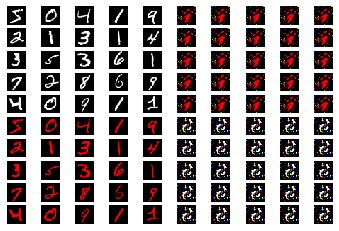

 25%|██▌       | 150/600 [01:45<04:36,  1.63it/s]W0405 22:05:48.388652 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:48.403834 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:48.429425 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:48.447609 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:48.464561 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:05:48.484826 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

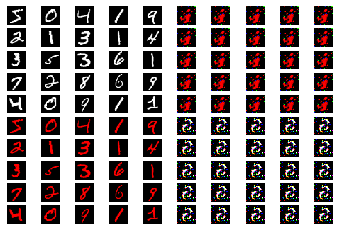

 33%|███▎      | 200/600 [02:21<04:06,  1.62it/s]W0405 22:06:24.096759 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:24.118546 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:24.137716 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:24.154223 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:24.183111 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:24.221927 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

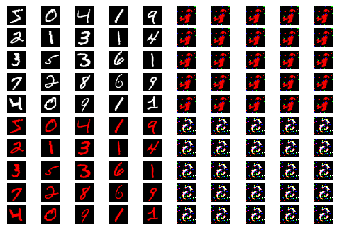

 42%|████▏     | 250/600 [02:55<03:31,  1.65it/s]W0405 22:06:58.043915 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:58.066106 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:58.080735 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:58.100967 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:58.119369 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:06:58.138136 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

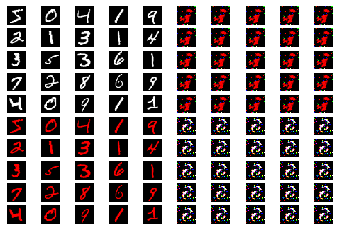

 50%|█████     | 300/600 [03:29<03:04,  1.63it/s]W0405 22:07:32.376081 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:07:32.390049 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:07:32.409815 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:07:32.430723 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:07:32.449093 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:07:32.464488 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

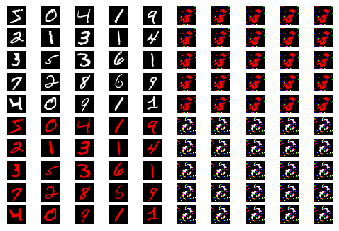

 58%|█████▊    | 350/600 [04:03<02:38,  1.58it/s]W0405 22:08:06.763941 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:06.777822 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:06.796613 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:06.811788 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:06.833711 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:06.859162 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

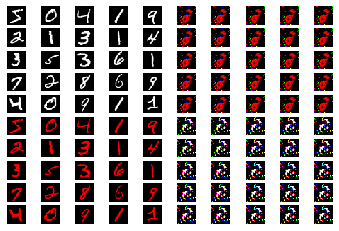

 67%|██████▋   | 400/600 [04:37<02:03,  1.61it/s]W0405 22:08:40.680102 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:40.697366 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:40.711785 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:40.732164 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:40.751547 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:08:40.774441 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

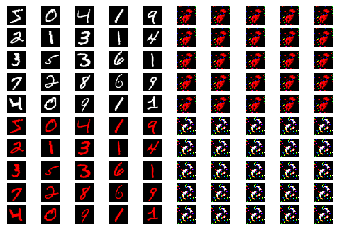

 75%|███████▌  | 450/600 [05:11<01:33,  1.61it/s]W0405 22:09:14.409551 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:14.426622 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:14.442298 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:14.460949 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:14.479178 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:14.501141 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

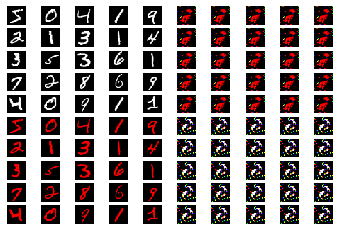

 83%|████████▎ | 500/600 [05:45<01:01,  1.63it/s]W0405 22:09:48.147557 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:48.161470 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:48.183614 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:48.197934 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:48.218222 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:09:48.237698 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

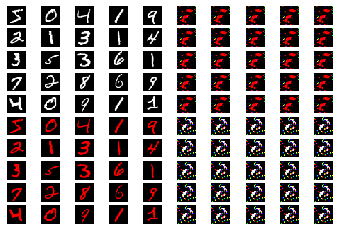

 92%|█████████▏| 550/600 [06:19<00:30,  1.63it/s]W0405 22:10:22.126768 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:22.145725 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:22.159956 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:22.179344 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:22.197903 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:22.219084 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

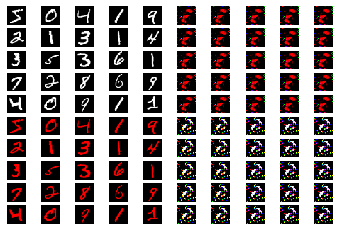

  0%|          | 0/600 [00:00<?, ?it/s]W0405 22:10:55.902827 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:55.917293 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:55.933693 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:55.952300 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:55.967002 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:55.988564 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:10:56.0089

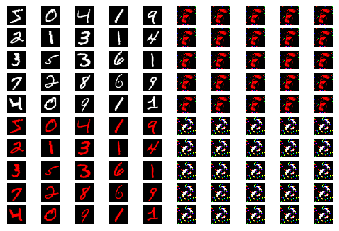

  8%|▊         | 50/600 [00:33<05:37,  1.63it/s]W0405 22:11:29.872989 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:11:29.889103 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:11:29.908617 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:11:29.924940 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:11:29.941617 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:11:29.962970 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:1

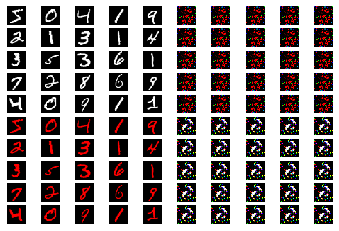

 17%|█▋        | 100/600 [01:07<05:08,  1.62it/s]W0405 22:12:03.798547 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:03.812365 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:03.832423 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:03.851337 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:03.869924 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:03.888049 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

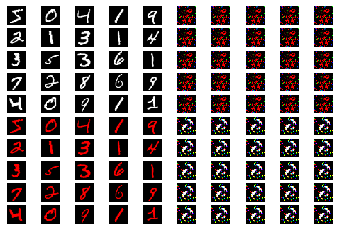

 25%|██▌       | 150/600 [01:42<04:39,  1.61it/s]W0405 22:12:38.170027 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:38.184157 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:38.203499 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:38.220774 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:38.239295 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:12:38.263005 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

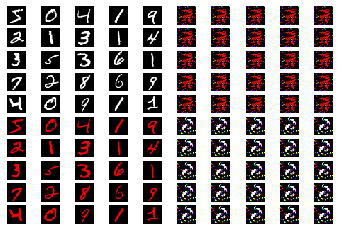

 33%|███▎      | 200/600 [02:16<04:03,  1.64it/s]W0405 22:13:12.089591 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:12.103828 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:12.124312 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:12.141294 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:12.160615 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:12.181713 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

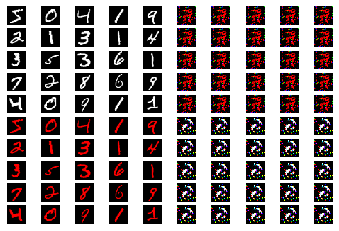

 42%|████▏     | 250/600 [02:50<03:34,  1.63it/s]W0405 22:13:46.126382 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:46.140442 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:46.159415 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:46.173711 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:46.194839 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:13:46.210251 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

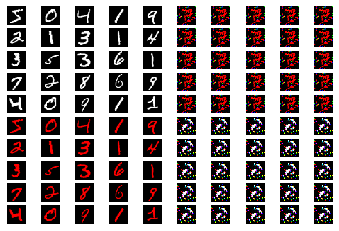

 50%|█████     | 300/600 [03:24<03:03,  1.63it/s]W0405 22:14:20.014416 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:14:20.028244 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:14:20.046521 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:14:20.060904 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:14:20.079998 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:14:20.101093 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

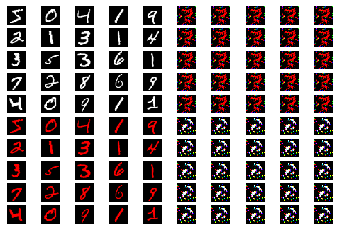

 58%|█████▊    | 350/600 [04:04<03:02,  1.37it/s]W0405 22:15:01.342691 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:01.387927 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:01.411418 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:01.435716 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:01.466233 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:01.513400 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

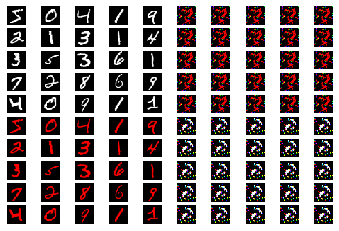

 67%|██████▋   | 400/600 [04:51<03:31,  1.06s/it]W0405 22:15:47.484880 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:47.507706 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:47.527189 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:47.542723 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:47.564507 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:15:47.585014 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

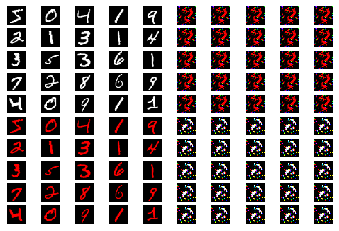

 75%|███████▌  | 450/600 [05:33<03:27,  1.38s/it]W0405 22:16:31.561738 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:16:31.580026 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:16:31.613641 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:16:31.667238 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:16:31.812750 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:16:31.890281 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

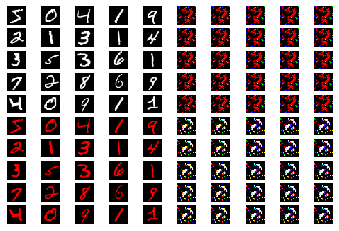

 83%|████████▎ | 500/600 [06:19<01:09,  1.44it/s]W0405 22:17:15.061102 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:15.077222 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:15.093262 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:15.107393 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:15.123070 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:15.138741 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

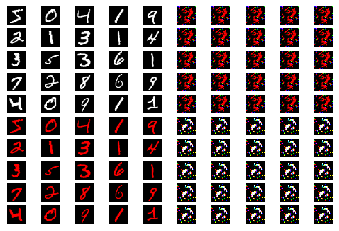

 92%|█████████▏| 550/600 [06:52<00:29,  1.69it/s]W0405 22:17:48.038493 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:48.052442 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:48.068878 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:48.083429 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:48.100131 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:17:48.115453 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

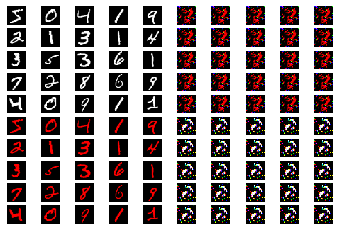

  0%|          | 0/600 [00:00<?, ?it/s]W0405 22:18:21.046408 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:21.063256 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:21.077850 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:21.092482 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:21.109056 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:21.124133 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:21.1402

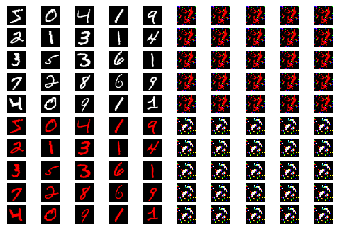

  8%|▊         | 50/600 [00:33<05:30,  1.66it/s]W0405 22:18:54.110885 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:54.125497 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:54.141303 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:54.155206 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:54.171303 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:18:54.186051 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:1

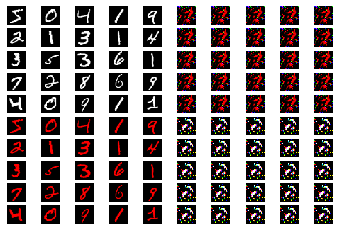

 17%|█▋        | 100/600 [01:05<04:59,  1.67it/s]W0405 22:19:26.919877 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:26.933786 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:26.949440 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:26.963270 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:26.978595 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:26.993203 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

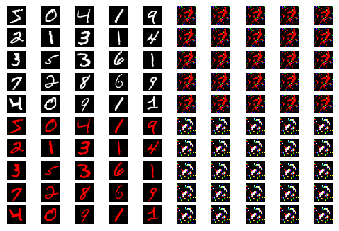

 25%|██▌       | 150/600 [01:38<04:30,  1.66it/s]W0405 22:19:59.717566 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:59.731716 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:59.747037 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:59.763088 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:59.777874 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:19:59.795483 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

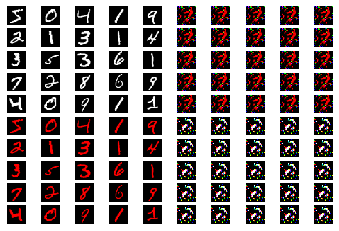

 33%|███▎      | 200/600 [02:19<04:17,  1.56it/s]W0405 22:20:40.144841 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:20:40.166038 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:20:40.188006 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:20:40.204069 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:20:40.223587 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:20:40.246107 4501568960 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 22:

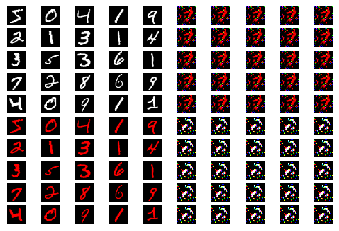

 35%|███▍      | 209/600 [02:29<05:16,  1.23it/s]

KeyboardInterrupt: 

In [21]:
train(10)